In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Data Loading and Preparation
df = pd.read_csv("Data/merged_crime_vacant.csv")

# First keep neighborhood information before converting to numpy
neighborhood_names = df['Neighborhood'].unique()

# Group by neighborhood and aggregate statistics
neighborhood_stats = df.groupby('Neighborhood').agg({
    'Vacant_Property_Count': ['mean', 'sum', 'count'],
    'Crime_Count': ['mean', 'sum']
}).reset_index()

# Flatten multi-index columns
neighborhood_stats.columns = ['_'.join(col).strip() for col in neighborhood_stats.columns.values]
neighborhood_stats.rename(columns={'Neighborhood_': 'Neighborhood'}, inplace=True)

# Create features and target
X = neighborhood_stats[[
    'Vacant_Property_Count_mean', 
    'Vacant_Property_Count_sum',
    'Vacant_Property_Count_count'
]].values
y = neighborhood_stats['Crime_Count_mean'].values.reshape(-1, 1)

# Get neighborhood names before splitting
all_neighborhoods = neighborhood_stats['Neighborhood'].values

# Train-Test Split
X_train, X_test, y_train, y_test, neighborhoods_train, neighborhoods_test = train_test_split(
    X, y, all_neighborhoods, test_size=0.2, random_state=42
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Neural Network
class NeighborhoodCrimePredictor(nn.Module):
    def __init__(self, input_size):
        super(NeighborhoodCrimePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = NeighborhoodCrimePredictor(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [6]:

# Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
        print(f'Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R-Squared: {r2:.2f}")

# Visualization by Neighborhood
results = pd.DataFrame({
    'Neighborhood': neighborhoods_test,
    'Actual': y_test.flatten(),
    'Predicted': y_pred.flatten()
}).sort_values('Actual')



Epoch 0: Train Loss: 7007.6328, Val Loss: 5572.9185
Epoch 100: Train Loss: 2417.5535, Val Loss: 2644.4829
Epoch 200: Train Loss: 2265.8740, Val Loss: 2374.6499
Epoch 300: Train Loss: 2245.1951, Val Loss: 2327.1658
Epoch 400: Train Loss: 2216.1128, Val Loss: 2259.3040
Epoch 500: Train Loss: 2181.2405, Val Loss: 2170.8027
Epoch 600: Train Loss: 2173.2046, Val Loss: 2119.7568
Epoch 700: Train Loss: 2172.7861, Val Loss: 2107.9033
Epoch 800: Train Loss: 2172.7642, Val Loss: 2106.3315
Epoch 900: Train Loss: 2172.7563, Val Loss: 2106.2939

Model Performance:
RMSE: 45.89
R-Squared: 0.47


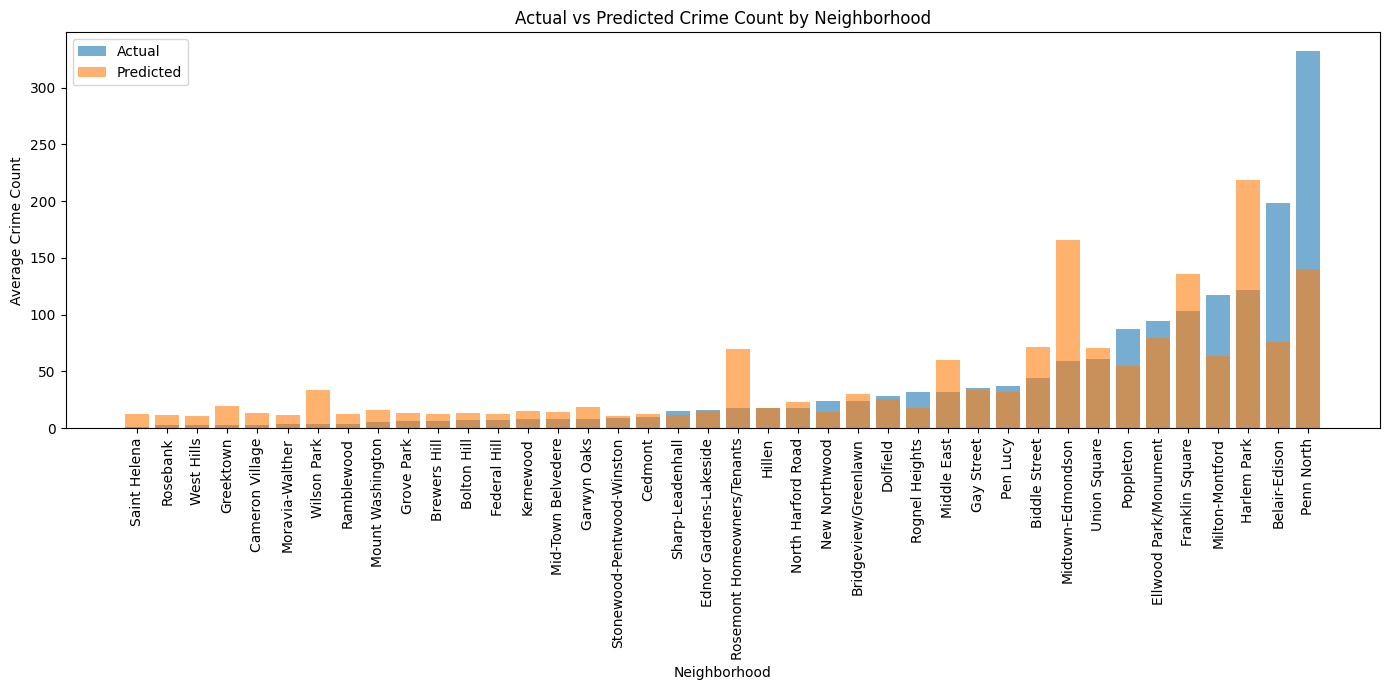

In [7]:
#Plotting

plt.figure(figsize=(14, 7))
plt.bar(range(len(results)), results['Actual'], alpha=0.6, label='Actual')
plt.bar(range(len(results)), results['Predicted'], alpha=0.6, label='Predicted')
plt.xticks(range(len(results)), results['Neighborhood'], rotation=90)
plt.xlabel("Neighborhood")
plt.ylabel("Average Crime Count")
plt.title("Actual vs Predicted Crime Count by Neighborhood")
plt.legend()
plt.tight_layout()
plt.show()